In [50]:
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import os
import pandas as pd
import numpy as np
import hashlib
from PIL import Image
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Pokedex functions

In [7]:
def make_pokedex(path="pokedex/pokemon.csv"):
    pokedex = pd.read_csv(path)
    return pokedex

In [8]:
# converts pokemon's name to corresponding pokemon's pokedex number
def pokemon_name_to_number(name):
    pokedex = make_pokedex()
    return pokedex.index[pokedex['Name'] == name].tolist()[0]

In [9]:
# converts pokemon's pokedex number to corresponding pokemon's name
def pokemon_number_to_name(number):
    pokedex = make_pokedex()
    return pokedex.iloc[number]['Name']

# Load Pokemon sprite data

In [20]:
sprites_number_name = []
# iterate over pokemon in sample directory
for i_pokemon, pokemon in enumerate(os.listdir('samples')):
    # iterate over images in each pokemon's directory
    for i_img, img in enumerate(os.listdir(os.path.join('samples', pokemon))):
        fp = os.path.join('samples', pokemon, img)
        # read in image
        sprite_image = cv2.imread(fp)
        # resize and convert image to np array
        resized_sprite_image = np.array(cv2.resize(sprite_image, (50, 50)))
        # convert to pokemon's pokedex number
        pokemon_number = pokemon_name_to_number(pokemon)
        # store image, number, name in cumulative list of other images
        sprites_number_name.append([resized_sprite_image, pokemon_number, pokemon])

# convert to pandas dataframe
data = pd.DataFrame(sprites_number_name, columns = ['image', 'number', 'name'])

## Check for duplicate images

In [21]:
def hash_image(image):
    # Convert the image array to bytes and then create an MD5 hash
    return hashlib.md5(image.tobytes()).hexdigest()

# Create a dictionary to store hashes and corresponding indices
hash_dict = {}

# Iterate through each image in the array
for i, image in enumerate(data['image']):
    # Get the hash of the current image
    image_hash = hash_image(image)

    # Check if the hash already exists in the dictionary
    if image_hash in hash_dict:
        hash_dict[image_hash].append(i)
    else:
        # If the hash is not in the dictionary, add it with the current index
        hash_dict[image_hash] = [i]

In [22]:
# Locate duplicate entries in the dataframe
duplicate_loc = [hash_dict[hash][1] for hash in hash_dict if len(hash_dict[hash]) > 1]

# Drop duplicate entries
data.drop(duplicate_loc, axis=0, inplace=True)

## Test Displaying Image

(50, 50, 3)


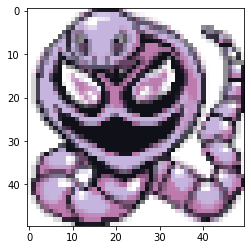

In [23]:
# load first image in dataframe
img1 = data.iloc[0]['image']
# print shape of image
print(img1.shape)
# plot image
plt.imshow(img1)
plt.show()

# Split sprite data and load into tensors

In [24]:
# load features
X = data['image']
# load labels
y = data['number']
# split data into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# concat feature and labels together
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# convert training data to tensor
tensor_X_train = torch.stack([torch.tensor(img, dtype=torch.float32) for img in data_train['image'].values])
tensor_X_train = torch.transpose(tensor_X_train, 1, 2)
tensor_X_train = torch.transpose(tensor_X_train, 1, 3)
tensor_X_train = tensor_X_train.to(device)
tensor_y_train = torch.tensor(data_train['number'].values)
tensor_y_train = tensor_y_train.to(device)
tensor_train = TensorDataset(tensor_X_train, tensor_y_train)

# convert test data to tensor
tensor_X_test = torch.stack([torch.tensor(img, dtype=torch.float32) for img in data_test['image'].values])
tensor_X_test = torch.transpose(tensor_X_test, 1, 2)
tensor_X_test = torch.transpose(tensor_X_test, 1, 3)
tensor_X_test = tensor_X_test.to(device)
tensor_y_test = torch.tensor(data_test['number'].values)
tensor_y_test = tensor_y_test.to(device)
tensor_test = TensorDataset(tensor_X_test, tensor_y_test)

# put tensor data into DataLoader
# train_loader = DataLoader(tensor_train, batch_size=16, shuffle=True)
# test_loader = DataLoader(tensor_test, batch_size=16, shuffle=True)

# CNN Model

In [111]:
# cnn model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),

            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.3),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 50 * 50, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            # nn.Linear(512, 1024),
            # nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256 * 50 * 50) 
        x = self.classifier(x)
        return x

# function to train model
def train_model(model, train_loader, criterion, optimizer, epoch, print_loss=False):
    model.train()
    running_loss = []
    total_samples = 0
    correct_samples = 0
    for inputs, labels in tqdm(train_loader):
    # for inputs, labels in train_loader:
        optimizer.zero_grad()
        pred = model(inputs)
        loss = criterion(pred, labels)
        running_loss.append(loss.item())
        
        _, predicted = torch.max(pred, 1)
        correct_samples += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        loss.backward()
        optimizer.step()
    if print_loss:
        print("Epoch {} - loss: {:.4} - training accuracy: {:.2%}".format(epoch + 1, np.mean(running_loss), correct_samples / total_samples))
    return correct_samples / total_samples

# function to evaluate the model
def evaluate_model(model, test_loader, criterion, top_k=False, k=10):
    correct = 0
    total = 0
    model.eval()
    predictions, labels = [], []
    eval_running_loss = []
    with torch.no_grad():
        for batch, label in test_loader:
            pred = model(batch)
            eval_loss = criterion(pred, label)
            eval_running_loss.append(eval_loss.item())

            if top_k:
                topk_values, topk_indices = torch.topk(pred, k=k, dim=1)
                for i, l in enumerate(label.tolist()):
                    if l in topk_indices.tolist()[i]:
                        correct += 1
                        predictions.append(l)
                        labels.append(l)
                    else:
                        predictions.append(topk_indices.tolist()[i][0])
                        labels.append(l)
                # print(label, topk_indices)
            else:
                correct += (torch.argmax(pred,dim=1)==label).sum().item()
                predictions.extend(torch.argmax(pred, dim=1).tolist())
                labels.extend(label.tolist())
    acc = correct/len(test_loader.dataset)

    # print(f"Test Acccuracy: {acc}")
    return acc, predictions, labels
    

# Accuracy, Precision, Recall, F1

In [126]:
def evaluate(predictions, labels):
    accuracy = accuracy_score(labels, predictions, normalize=True)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)
    
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 Score: ', f1)

# Function to train and test CNN model on sprite data

In [27]:
def train_test_model(lr, batch_size, weight_decay, optimizer_name, epochs, print_loss=False):
    cnn = CNN(num_classes=50)
    cnn = cnn.to(device)
    
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_name == 'adam':
        optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'sgd':
        optimizer = optim.SGD(cnn.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_name == 'rmsprop':
        optimizer = optim.RMSprop(cnn.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")
    
    
    train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=True)
    
    # Training loop
    # for epoch in tqdm(range(epochs)):  # Adjust the number of epochs as needed
    for epoch in range(epochs):
        training_accuracy = train_model(cnn, train_loader, criterion, optimizer, epoch, print_loss=print_loss)
    
    # Evaluate the model on the validation set
    test_accuracy, predictions, labels = evaluate_model(cnn, test_loader, criterion)
    
    print(f"LR: {lr}, Batch Size: {batch_size}, Weight Decay: {weight_decay}, Optimizer: {optimizer_name}, Training Accuracy: {round(training_accuracy, 5)}, Test Accuracy: {round(test_accuracy, 5)}")
    
    evaluate(predictions, labels)

# Train and test model

In [23]:
train_test_model(lr=4e-4, batch_size=16, weight_decay=1e-4, optimizer_name='sgd', epochs=10, print_loss=True)

100%|██████████| 136/136 [04:04<00:00,  1.79s/it]


Epoch 1 - loss: 2.877 - training accuracy: 25.25%


100%|██████████| 136/136 [04:03<00:00,  1.79s/it]


Epoch 2 - loss: 1.133 - training accuracy: 66.20%


100%|██████████| 136/136 [03:56<00:00,  1.74s/it]


Epoch 3 - loss: 0.6308 - training accuracy: 80.75%


100%|██████████| 136/136 [03:57<00:00,  1.74s/it]


Epoch 4 - loss: 0.3824 - training accuracy: 88.37%


100%|██████████| 136/136 [04:07<00:00,  1.82s/it]


Epoch 5 - loss: 0.2455 - training accuracy: 92.52%


100%|██████████| 136/136 [04:02<00:00,  1.79s/it]


Epoch 6 - loss: 0.1496 - training accuracy: 95.98%


100%|██████████| 136/136 [04:32<00:00,  2.00s/it]


Epoch 7 - loss: 0.1065 - training accuracy: 97.23%


100%|██████████| 136/136 [04:11<00:00,  1.85s/it]


Epoch 8 - loss: 0.07196 - training accuracy: 98.34%


100%|██████████| 136/136 [03:52<00:00,  1.71s/it]


Epoch 9 - loss: 0.06283 - training accuracy: 98.85%


100%|██████████| 136/136 [03:51<00:00,  1.70s/it]


Epoch 10 - loss: 0.04589 - training accuracy: 99.17%
LR: 0.0004, Batch Size: 16, Weight Decay: 0.0001, Optimizer: sgd, Training Accuracy: 0.99169, Test Accuracy: 0.80409


# Load trained model and test on sprite data

In [73]:
# load state dict of trained model
loaded_state_dict = torch.load('cnn_state_dict.pth', map_location=torch.device('cpu'))
cnn_load = CNN(num_classes=50)
cnn_load.load_state_dict(loaded_state_dict)

criterion = nn.CrossEntropyLoss()
batch_size = 16

test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=True)

# test model on sprite test data
test_accuracy, predictions, labels = evaluate_model(cnn_load, test_loader, criterion)
print(test_accuracy)
evaluate(predictions, labels)

0.8180839612486545
Accuracy:  0.8180839612486545
Precision:  0.8294961116995407
Recall:  0.8180839612486545
F1 Score:  0.8143982878538758


# Load Pokemon battle image data and convert to tensor

In [120]:
battle_number_name = []
# iterate over pokemon in sample directory
for i_pokemon, pokemon_file in enumerate(os.listdir('find_pkm_in_battle/ScreenShoots/output')):
    # find start of pokemon name
    start = 0
    while not ('a' <= pokemon_file[start] <= 'z'):
        start += 1
    # find end of pokemon name
    end = start
    while 'a' <= pokemon_file[end] <= 'z':
        end += 1
    # pokemon name
    pokemon = pokemon_file[start:end]
    # check if pokemon was trained by the model
    if pokemon_name_to_number(pokemon) <= 50:
        fp = os.path.join('find_pkm_in_battle/ScreenShoots/output',pokemon_file)
        # read in image
        sprite_image = cv2.imread(fp)
        # resize and convert image to np array
        resized_sprite_image = np.array(cv2.resize(sprite_image, (50, 50)))
        # convert to pokemon's pokedex number
        pokemon_number = pokemon_name_to_number(pokemon)
        # store image, number, name in cumulative list of other images
        battle_number_name.append([resized_sprite_image, pokemon_number, pokemon])

# convert to pandas dataframe
data_battle = pd.DataFrame(battle_number_name, columns = ['image', 'number', 'name'])

# load features
X_battle = data_battle['image']
# load labels
y_battle = data_battle['number']

# concat feature and labels together
data_battle_test = pd.concat([X_battle, y_battle], axis=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# convert battle data to tensor
tensor_X_battle = torch.stack([torch.tensor(img, dtype=torch.float32) for img in data_battle_test['image'].values])
tensor_X_battle = torch.transpose(tensor_X_battle, 1, 2)
tensor_X_battle = torch.transpose(tensor_X_battle, 1, 3)
tensor_X_battle = tensor_X_battle.to(device)
tensor_y_battle = torch.tensor(data_battle_test['number'].values)
tensor_y_battle = tensor_y_battle.to(device)
tensor_battle = TensorDataset(tensor_X_battle, tensor_y_battle)

# Load trained model and test on battle data

In [127]:
# load state dict of trained model
loaded_state_dict = torch.load('cnn_state_dict.pth', map_location=torch.device('cpu'))
cnn_load = CNN(num_classes=50)
cnn_load.load_state_dict(loaded_state_dict)

criterion = nn.CrossEntropyLoss()
batch_size = 16

# put battle tensor into DataLoader
battle_loader = DataLoader(tensor_battle, batch_size=batch_size, shuffle=True)

# test model on battle data
test_accuracy, predictions, labels = evaluate_model(cnn_load, battle_loader, criterion, top_k=True, k=5)
evaluate(predictions, labels)


Accuracy:  0.14666666666666667
Precision:  0.1961056487372277
Recall:  0.14666666666666667
F1 Score:  0.13594465962887017
